In [1]:
from glob import glob
import pint.models as model
# pip install git+https://github.com/telegraphic/pygdsm
# or install from source (git clone https://github.com/telegraphic/pygdsm)
import pygdsm
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy import units as u, constants as c
from astropy.coordinates import SkyCoord, ICRS, Galactic
from scipy.optimize import curve_fit
import scipy.integrate

In [2]:
def get_prof_nbin(fname):
    x,y,z,intensity = np.loadtxt(fname,unpack=True,dtype='float',skiprows=1)
    nbin = len(intensity)
    
    return intensity,nbin

def get_on_binwidth(folded_profile,threshold = 0.925,interpulse=False):
    
    box_size = []
    max_conv = []
    nbin = len(folded_profile)
    for jj in range(1,nbin):
        box = np.zeros(nbin)
        box_width = jj
        box_size.append(box_width)
        box[0:box_width] += 1.0
        conv = np.convolve(box,folded_profile)
        max_conv.append(np.max(conv))
    
    on_width = np.argmin((np.array(max_conv)-threshold)**2) + 1
    return on_width

def roll_prof(profile,max_phase=0.3):
    nbin = len(profile)
    max_ind = np.argmax(profile)
    shift = int(max_phase * nbin) - max_ind
    return np.roll(profile,shift)
    
def get_si(freq1,flux1,freq2,flux2):
    si = np.log10(flux2/flux1)/np.log10(freq2/freq1)
    return si

def powerlaw(x, a, b):
    return a*x**b

def get_si_multi(freqs,fluxes,flux_errs):
    pars, pcov = curve_fit(f=powerlaw, xdata=freqs, ydata=fluxes, sigma = flux_errs, p0=[0, 0], bounds = ([-np.inf, -5.],[np.inf,2.]))
    coeff  = pars[0]
    si     = pars[1]
    si_err = np.sqrt(np.diag(pcov))[1]
    return si, si_err, coeff

class OnOff:
    """
    This class contains the functionality to parse .onoff files;
    the corresponding object contains relevant information.
    """
    def __init__(self, filename):
        """
        Initialization method.

        Parses and stores header values, profile intensities, and on/off info.

        Parameters
        ==========
        filename (str) : path to the .onoff file
        """
        self.filename = filename
        self.ip_wid = 0
        
        with open(self.filename,'r') as f:
            onoff_contents = f.readlines()
        
        for line in onoff_contents:

            # Parse header to get relevant profile info
            if line.startswith("#"):
                for item in line.split():
                    if "tobs" in item:
                        self.tobs = float(item.split("=")[1].replace(",",""))
                    elif "snr" in item:
                        self.snr = float(item.split("=")[1].replace(",",""))
                    elif "duty" in item:
                        self.duty = float(item.split("=")[1].replace(",",""))
                        self.profile, self.onoff = np.loadtxt(self.filename,dtype='float',unpack=True)
                        self.nbin = len(self.profile)
                        self.wid = int(np.round(self.nbin * self.duty)) 
                    elif "width" in item:
                        self.wid = int(item.split("=")[1].replace(",","")) # (integer) main-pulse box_width
                    elif "interpulse" in item:
                        self.ip_wid = int(item.split("=")[1].replace(",","")) # (integer) interpulse box_width
                    elif "degradation" in item:
                        self.deg = float(item.split("=")[1].replace(",",""))
                    elif "file" in item:
                        self.prof_file = item.split("=")[1]
                    else:
                        continue
            else:
                continue

In [3]:
"""Observation times (tobs) listed here come from `vap -c length` on the original
archives and degradation is based on position offset during observing. I
generated profiles for the most part only using scans where the position offset
caused < 10% degradation (deg=0.9), but in some cases that was not possible.

Degradation values (deg) come from work in data/profile_pos_check.ipynb, which was
used to find a suitable list of files to use, which in most cases, meant accepting
degradation in SNR up to 10% due to position offset. In some cases (e.g. J1122), a
coherent timing solution was not available until late in the follow-up campaign, so
including enough data to generate a decent profile meant also accepting a different
deg threshold. Note 10% degradation equates to deg = 0.9.
"""

datadir = "data/"

profsfreqstobs = np.loadtxt(f"{datadir}lengths.dat", dtype=str)
psrsfreqsdegs = np.loadtxt(f"{datadir}deg_factors.dat", skiprows=1, dtype=str)

prof57   = []
tobs57   = []
deg57    = []
prof149  = []
tobs149  = []
deg149   = []
prof350  = []
tobs350  = []
deg350   = []
prof430  = []
tobs430  = []
deg430   = []
prof820  = []
tobs820  = []
deg820   = []
prof1380 = []
tobs1380 = []
deg1380  = []
prof1500 = []
tobs1500 = []
deg1500  = []
prof2000 = []
tobs2000 = []
deg2000  = []

DF_dict = {}

for pfd in psrsfreqsdegs:
    psr  = pfd[0]
    freq = pfd[1]
    deg  = pfd[2]
    psrfreq = f"{psr}_{freq}MHz"
    DF_dict[psrfreq] = float(deg)

for pft in profsfreqstobs:
    psr, freq, tobs = pft[0], pft[1][:-2], float(pft[2])
    fnamebase = f"{psr}_{freq}"
    prof      = f"{datadir}{fnamebase}MHz_fiore+23.profile"
    if freq == "57.15":
        prof57 = np.append(prof57, prof)
        tobs57 = np.append(tobs57, tobs)
        df     = DF_dict[f"{fnamebase}MHz"]
        deg57  = np.append(deg57, df)
    elif freq == "149":
        prof149 = np.append(prof149, prof)
        tobs149 = np.append(tobs149, tobs)
        df      = DF_dict[f"{fnamebase}MHz"]
        deg149  = np.append(deg149, df)
    elif freq == "350":
        prof350 = np.append(prof350, prof)
        tobs350 = np.append(tobs350, tobs)
        df      = DF_dict[f"{fnamebase}MHz"]
        deg350  = np.append(deg350, df)
#         if psr == "J0415+6111":
#             deg = 0.77
#         elif psr == "J1505-2524":
#             deg = 0.6
#         elif psr == "J1530-2114":
#             deg = 0.8
#         elif psr == "J1913+3732":
#             deg = 0.1
#         elif psr == "J1929+6630":
#             deg = 0.3
#         elif psr == "J1930+6205":
#             deg = 0.6
#         elif psr == "J2104+2830":
#             deg = 0.3
#         elif psr == "J2115+6702":
#             deg = 0.85
#         elif psr == "J2145+2158":
#             deg = 0.59
#         elif psr == "J2210+5712":
#             deg = 0.5
#         else:
#             deg = 0.9
#         deg350  = np.append(deg350, deg)
    elif freq == "430":
        prof430 = np.append(prof430, prof)
        tobs430 = np.append(tobs430, tobs)
        df      = DF_dict[f"{fnamebase}MHz"]
        deg430  = np.append(deg430, df)
    elif freq == "820":
        prof820 = np.append(prof820, prof)
        tobs820 = np.append(tobs820, tobs)
        df      = DF_dict[f"{fnamebase}MHz"]
        deg820  = np.append(deg820, df)
#         if psr == "J0141+6303":
#             deg = 0.5
#         elif psr == "J0415+6111":
#             deg = 0.75
#         elif psr == "J1530-2114":
#             deg = 0.7
#         elif psr == "J1913+3732":
#             deg = 0.1
#         elif psr == "J1929+6630":
#             deg = 0.8
#         elif psr == "J1930+6205":
#             deg = 0.75
#         elif psr == "J2104+2830":
#             deg = 0.75
#         elif psr == "J2210+5712":
#             deg = 0.8
#         else: deg = 0.9
#         deg820  = np.append(deg820, deg)
    elif freq == "1380":
        prof1380 = np.append(prof1380, prof)
        tobs1380 = np.append(tobs1380, tobs)
#         deg1380  = np.append(deg1380, 0.9)
        df       = DF_dict[f"{fnamebase}MHz"]
        deg1380  = np.append(deg1380, df)
    elif freq == "1500":
        prof1500 = np.append(prof1500, prof)
        tobs1500 = np.append(tobs1500, tobs)
#         deg1500  = np.append(deg1500, 0.9)
        df       = DF_dict[f"{fnamebase}MHz"]
        deg1500  = np.append(deg1500, df)
    elif freq == "2000":
        prof2000 = np.append(prof2000, prof)
        tobs2000 = np.append(tobs2000, tobs)
#         deg2000  = np.append(deg2000, 0.9)
        df       = DF_dict[f"{fnamebase}MHz"]
        deg2000  = np.append(deg2000, df)
    else:
        print(f"This is a weird frequency: {freq}")
        break

#print(f"Number of 350/820 profiles: {len(prof350)}/{len(prof820)}")

In [110]:
def onoff(OBSERVING_FREQ, index, OVERWRITE_ONOFF=False, box_width=None, zoom=False):
    """The convolution makes boxes match profiles better for plotting, but
    this is an iterative/by-eye process of finding box widths that match
    the full width of the on-pulse. Change index/box_width until the plot looks 
    good and a .onoff file will be written with useful info in the header and 1/0
    denoting bins where the pulsar signal is on/off. Note that setting the
    OVERWRITE_ONOFF variable to False makes this cell read from an existing
    file and display the profiles/box/values recorded there.

    To iterate from existing work, run the cell to get a sense for box_width, set
    that variable accordingly, turn on OVERWRITE_ONOFF, then iterate and tweak the
    box_width as necessary. Finally turn off OVERWRITE_ONOFF and check results with
    a final run."""

    if OBSERVING_FREQ == 57.15:
        tobs = tobs57[index]
        ff = prof57[index]
        degradation = deg57[index]  
    if OBSERVING_FREQ == 149:
        tobs = tobs149[index]
        ff = prof149[index]
        degradation = deg149[index]
    elif OBSERVING_FREQ == 350:
        tobs = tobs350[index]
        ff = prof350[index]
        degradation = deg350[index]
    elif OBSERVING_FREQ == 430:
        tobs = tobs430[index]
        ff = prof430[index]
        degradation = deg430[index]
    elif OBSERVING_FREQ == 820:
        tobs = tobs820[index]
        ff = prof820[index]
        degradation = deg820[index]
    elif OBSERVING_FREQ == 1380:
        tobs = tobs1380[index]
        ff = prof1380[index]
        degradation = deg1380[index]
    elif OBSERVING_FREQ == 1500:
        tobs = tobs1500[index]
        ff = prof1500[index]
        degradation = deg1500[index]
    elif OBSERVING_FREQ == 2000:
        tobs = tobs2000[index]
        ff = prof2000[index]
        degradation = deg2000[index]

    # check if .onoff file already exists, use it 
    of = ff.replace('profile','onoff')
    print(of)
    if os.path.exists(of):
        print(f" ON/OFF file exists: {of}")
        oo_obj = OnOff(of)
        print(f"Width (from .onoff): {oo_obj.wid}")
        print(f"Duty Cycle (from .onoff): {oo_obj.duty}")
        print(f"Degr. (from .onoff): {oo_obj.deg}")
        print(f"  SNR (from .onoff): {oo_obj.snr}")
        profile, on_window, nbin = oo_obj.profile, oo_obj.onoff, oo_obj.nbin
        on_window *= np.max(profile)
        print()

    if OVERWRITE_ONOFF:
        print(f"File: {ff}")
        prof,nbin = get_prof_nbin(ff)
        normed_prof = prof/np.sum(prof)
        profile = roll_prof(normed_prof,max_phase=0.5)
        
        try:
            dummy_box_width = oo_obj.wid
        except:
            dummy_box_width = 20
            
        box = np.zeros(nbin)
        
        interpulse_width = 0
        if ('J1816' in ff) and ('350MHz' in ff):
            ipi = 72
            ipf = 95
            box[ipi:ipf] += 0.3*max(profile) # Add for J1816, 350 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        elif ('J1816' in ff) and ('820MHz' in ff):
            ipi = 75
            ipf = 95
            box[ipi:ipf] += 0.15*max(profile) # Add for J1816, 820 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        elif ('J0214' in ff) and ('820MHz' in ff):
            ipi = 86
            ipf = 115
            box[ipi:ipf] += 0.1*max(profile) # Add for J0214, 820 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        elif ('J1434' in ff) and ('350MHz' in ff):
            ipi = 62
            ipf = 69
            box[ipi:ipf] += 0.1*max(profile) # Add for J1434, 350 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        elif ('J1434' in ff) and ('820MHz' in ff):
            ipi = 61
            ipf = 74
            box[ipi:ipf] += 0.22*max(profile) # Add for J1434, 820 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        elif ('J1434' in ff) and ('1500MHz' in ff):
            ipi = 60
            ipf = 70
            box[ipi:ipf] += 0.36*max(profile) # Add for J1434, 1500 MHz
            interpulse_width = len(box[ipi:ipf])
            #dummy_box_width -= interpulse_width
        
        if box_width:
            pass
        else:
            box_width = dummy_box_width
            
        box[0:box_width] += max(profile)
        conv = np.convolve(box,profile)
        conv_box = np.roll(box,nbin-box_width)
        on_window = np.roll(conv_box,np.argmax(conv)+1)
        off_inds = np.where(on_window == 0.0)

        box_width = len(np.where(box != 0.0)[0])
        print(f"ON Phase Bins: {box_width}")

        # Calculate S/N
        off_mean = np.mean(profile[off_inds])
        off_std = np.std(profile[off_inds])
        snr = np.sum((profile-off_mean)/(off_std*np.sqrt(box_width)))
        print(f"SNR: {snr:.2f}")
        
        # Calculate duty cycle
        on_inds = np.where(on_window != 0.0)
        temp_inds = np.array([],dtype=int)
        last_oi = 0
        area = 0.0
        naive_area=True
        for oi in on_inds[0]:
            if oi==last_oi+1 or len(temp_inds)==0:
                temp_inds = np.append(temp_inds,int(oi))
            else:
                naive_area=False
                area += scipy.integrate.simps(profile[temp_inds])
            last_oi = oi
        if naive_area:
            area = scipy.integrate.simps(profile[on_inds])
        else:
            area += scipy.integrate.simps(profile[temp_inds])
        W_eq = area/np.max(profile) # width (in bins) of box with equivalent area and peak height of profile
        duty = W_eq/nbin
        print(f"Duty cycle: {duty:.2f}")

    plt.plot(on_window)
    plt.plot(profile)
    if zoom:
        plt.xlim(min(on_inds[0])-zoom, max(on_inds[0])+zoom)
    plt.plot(np.zeros(nbin)+0.1*np.max(profile),ls='--',color='gray')

    # WRITE ROLLED PROFILE + CORRESPONDING ON/OFF INFO TO FILE (.onoff)
    if OVERWRITE_ONOFF:
        onoff = [np.ceil(x) for x in on_window]
        with open(of,'w') as f:
            file_only = ff.split("/")[1]
            #duty=box_width/nbin
            #write header
            f.write(f"# file={file_only} \n")
            if interpulse_width != 0:
                f.write(f"# tobs={tobs}, snr={snr:.5f}, duty={duty:.5f}, width={box_width-interpulse_width}, interpulse={interpulse_width}, degradation={degradation} \n")
            else:
                f.write(f"# tobs={tobs}, snr={snr:.5f}, duty={duty:.5f}, width={box_width}, degradation={degradation} \n")
            for pp,oo in zip(profile,onoff):
                f.write(f"{pp:.8f} {oo}\n")

data/J0636+5128_2000MHz_fiore+23.onoff
 ON/OFF file exists: data/J0636+5128_2000MHz_fiore+23.onoff
Width (from .onoff): 18
Duty Cycle (from .onoff): 0.05423
Degr. (from .onoff): 1.0
  SNR (from .onoff): 153.61901



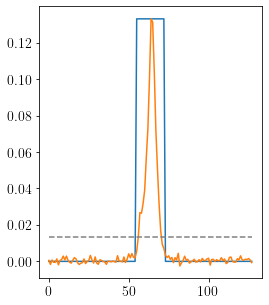

In [152]:
onoff(2000,
      0#, OVERWRITE_ONOFF = True, box_width = 11
      ,zoom = False   # if not False, number of phase bins on either side of profile
      #,zoom = 5      # zoom may not work for profiles with interpulses, only works if overwriting
      )
plt.show()

data/J1327+3423_57.15MHz_fiore+23.onoff
 ON/OFF file exists: data/J1327+3423_57.15MHz_fiore+23.onoff
Width (from .onoff): 15
Duty Cycle (from .onoff): 0.0337
Degr. (from .onoff): 1.0
  SNR (from .onoff): 114.04365



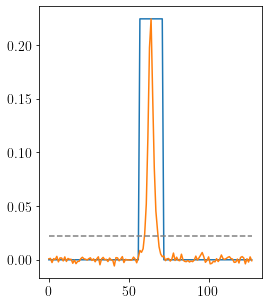

data/J0214+5222_149MHz_fiore+23.onoff
 ON/OFF file exists: data/J0214+5222_149MHz_fiore+23.onoff
Width (from .onoff): 14
Duty Cycle (from .onoff): 0.05749
Degr. (from .onoff): 1.0
  SNR (from .onoff): 65.30979



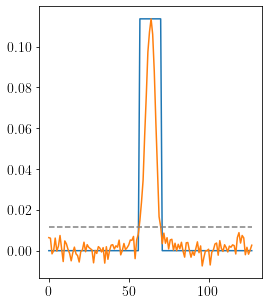

data/J0032+6946_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J0032+6946_350MHz_fiore+23.onoff
Width (from .onoff): 11
Duty Cycle (from .onoff): 0.03815
Degr. (from .onoff): 0.97
  SNR (from .onoff): 21.13325



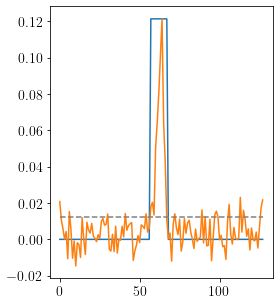

data/J0141+6303_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J0141+6303_350MHz_fiore+23.onoff
Width (from .onoff): 17
Duty Cycle (from .onoff): 0.05035
Degr. (from .onoff): 0.92
  SNR (from .onoff): 33.84028



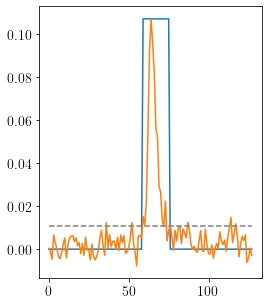

data/J0214+5222_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J0214+5222_350MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.04588
Degr. (from .onoff): 1.0
  SNR (from .onoff): 53.91344



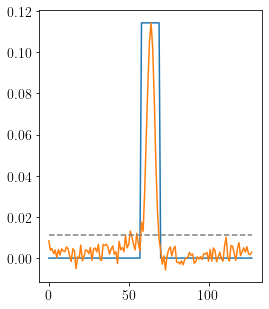

data/J0415+6111_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J0415+6111_350MHz_fiore+23.onoff
Width (from .onoff): 10
Duty Cycle (from .onoff): 0.04404
Degr. (from .onoff): 0.77
  SNR (from .onoff): 10.70004



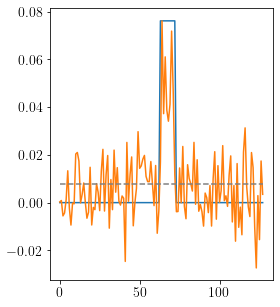

data/J0636+5128_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J0636+5128_350MHz_fiore+23.onoff
Width (from .onoff): 32
Duty Cycle (from .onoff): 0.04707
Degr. (from .onoff): 1.0
  SNR (from .onoff): 142.33739



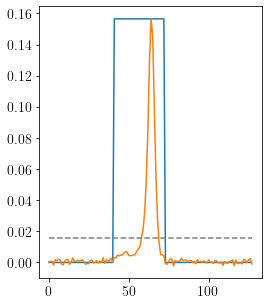

data/J1239+3239_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1239+3239_350MHz_fiore+23.onoff
Width (from .onoff): 57
Duty Cycle (from .onoff): 0.2449
Degr. (from .onoff): 1.0
  SNR (from .onoff): 82.53917



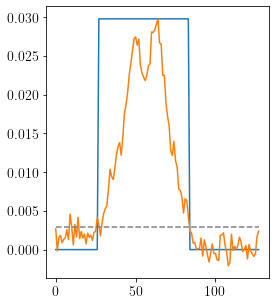

data/J1327+3423_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1327+3423_350MHz_fiore+23.onoff
Width (from .onoff): 14
Duty Cycle (from .onoff): 0.02903
Degr. (from .onoff): 1.0
  SNR (from .onoff): 111.86657



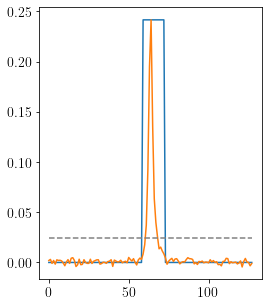

data/J1434+7257_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1434+7257_350MHz_fiore+23.onoff
Width (from .onoff): 10
Duty Cycle (from .onoff): 0.08309
Degr. (from .onoff): 1.0
  SNR (from .onoff): 80.01124



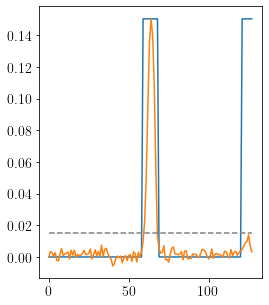

data/J1505-2524_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1505-2524_350MHz_fiore+23.onoff
Width (from .onoff): 6
Duty Cycle (from .onoff): 0.01903
Degr. (from .onoff): 0.69
  SNR (from .onoff): 17.51675



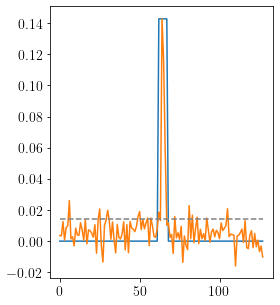

data/J1530-2114_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1530-2114_350MHz_fiore+23.onoff
Width (from .onoff): 7
Duty Cycle (from .onoff): 0.02618
Degr. (from .onoff): 0.81
  SNR (from .onoff): 26.14293



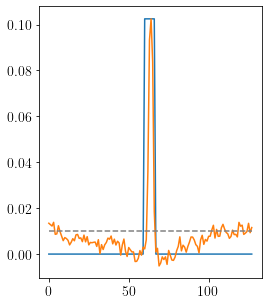

data/J1816+4510_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1816+4510_350MHz_fiore+23.onoff
Width (from .onoff): 29
Duty Cycle (from .onoff): 0.2624
Degr. (from .onoff): 1.0
  SNR (from .onoff): 74.98872



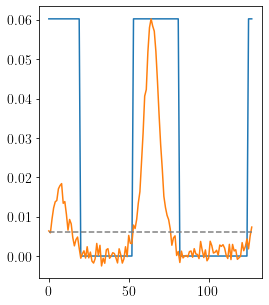

data/J1913+3732_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1913+3732_350MHz_fiore+23.onoff
Width (from .onoff): 6
Duty Cycle (from .onoff): 0.01947
Degr. (from .onoff): 0.39
  SNR (from .onoff): 47.15642



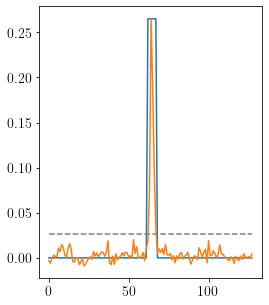

data/J1929+6630_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1929+6630_350MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.02905
Degr. (from .onoff): 0.42
  SNR (from .onoff): 12.1747



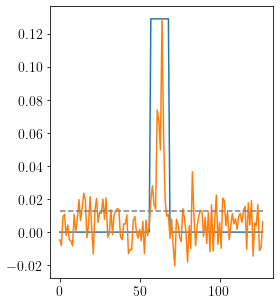

data/J1930+6205_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J1930+6205_350MHz_fiore+23.onoff
Width (from .onoff): 5
Duty Cycle (from .onoff): 0.01758
Degr. (from .onoff): 0.66
  SNR (from .onoff): 18.28888



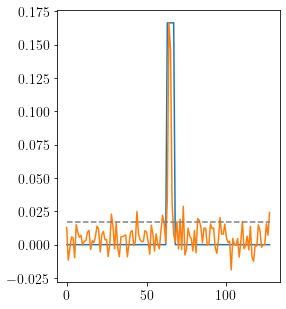

data/J2104+2830_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2104+2830_350MHz_fiore+23.onoff
Width (from .onoff): 8
Duty Cycle (from .onoff): 0.02011
Degr. (from .onoff): 0.4
  SNR (from .onoff): 13.33357



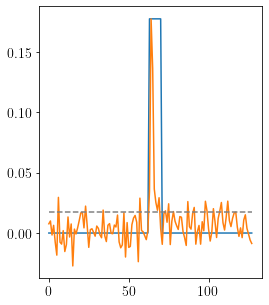

data/J2115+6702_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2115+6702_350MHz_fiore+23.onoff
Width (from .onoff): 9
Duty Cycle (from .onoff): 0.03829
Degr. (from .onoff): 0.85
  SNR (from .onoff): 8.43021



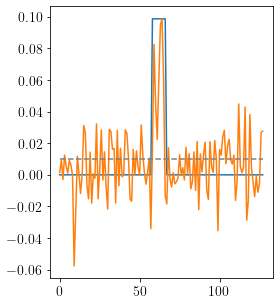

data/J2145+2158_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2145+2158_350MHz_fiore+23.onoff
Width (from .onoff): 8
Duty Cycle (from .onoff): 0.02533
Degr. (from .onoff): 0.59
  SNR (from .onoff): 10.05702



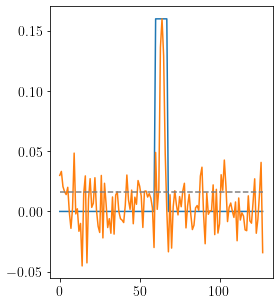

data/J2210+5712_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2210+5712_350MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.05802
Degr. (from .onoff): 0.5
  SNR (from .onoff): 8.98732



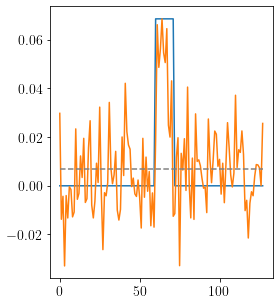

data/J2326+6243_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2326+6243_350MHz_fiore+23.onoff
Width (from .onoff): 16
Duty Cycle (from .onoff): 0.05048
Degr. (from .onoff): 0.91
  SNR (from .onoff): 10.39139



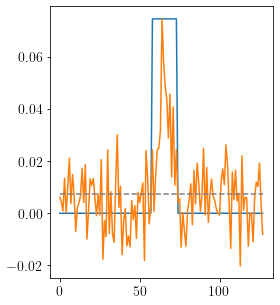

data/J2354-2250_350MHz_fiore+23.onoff
 ON/OFF file exists: data/J2354-2250_350MHz_fiore+23.onoff
Width (from .onoff): 15
Duty Cycle (from .onoff): 0.02363
Degr. (from .onoff): 0.95
  SNR (from .onoff): 60.67099



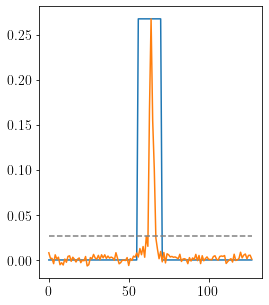

data/J1327+3423_430MHz_fiore+23.onoff
 ON/OFF file exists: data/J1327+3423_430MHz_fiore+23.onoff
Width (from .onoff): 23
Duty Cycle (from .onoff): 0.03004
Degr. (from .onoff): 1.0
  SNR (from .onoff): 1108.49783



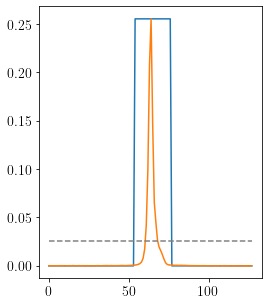

data/J0032+6946_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0032+6946_820MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.02331
Degr. (from .onoff): 1.0
  SNR (from .onoff): 99.71509



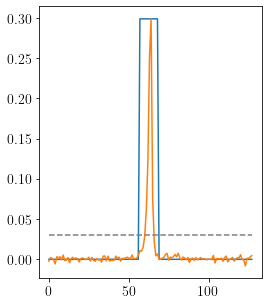

data/J0141+6303_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0141+6303_820MHz_fiore+23.onoff
Width (from .onoff): 11
Duty Cycle (from .onoff): 0.028
Degr. (from .onoff): 0.58
  SNR (from .onoff): 64.97477



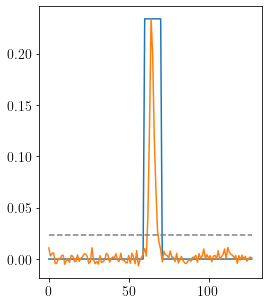

data/J0214+5222_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0214+5222_820MHz_fiore+23.onoff
Width (from .onoff): 47
Duty Cycle (from .onoff): 0.21323
Degr. (from .onoff): 1.0
  SNR (from .onoff): 82.30012



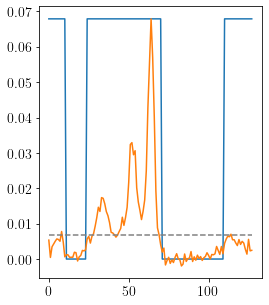

data/J0415+6111_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0415+6111_820MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.04337
Degr. (from .onoff): 0.79
  SNR (from .onoff): 57.96137



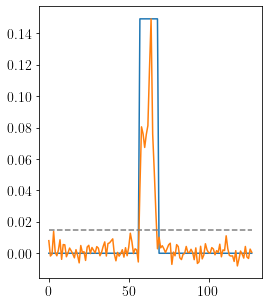

data/J0636+5128_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0636+5128_820MHz_fiore+23.onoff
Width (from .onoff): 28
Duty Cycle (from .onoff): 0.04973
Degr. (from .onoff): 0.98
  SNR (from .onoff): 872.37513



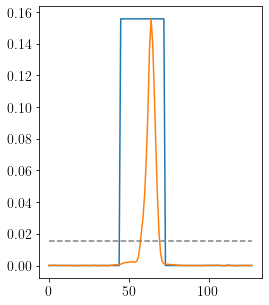

data/J0957-0619_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J0957-0619_820MHz_fiore+23.onoff
Width (from .onoff): 13
Duty Cycle (from .onoff): 0.01971
Degr. (from .onoff): 0.94
  SNR (from .onoff): 52.08517



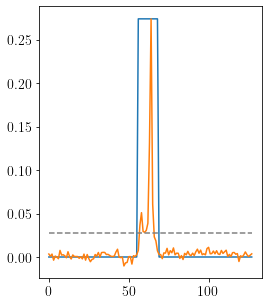

data/J1239+3239_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1239+3239_820MHz_fiore+23.onoff
Width (from .onoff): 87
Duty Cycle (from .onoff): 0.34072
Degr. (from .onoff): 0.99
  SNR (from .onoff): 155.68508



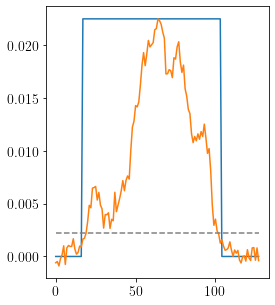

data/J1327+3423_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1327+3423_820MHz_fiore+23.onoff
Width (from .onoff): 23
Duty Cycle (from .onoff): 0.03031
Degr. (from .onoff): 1.0
  SNR (from .onoff): 383.21936



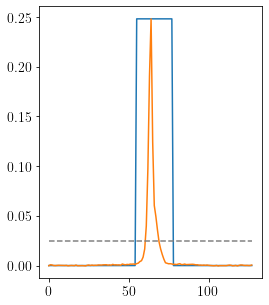

data/J1434+7257_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1434+7257_820MHz_fiore+23.onoff
Width (from .onoff): 14
Duty Cycle (from .onoff): 0.09714
Degr. (from .onoff): 1.0
  SNR (from .onoff): 104.75181



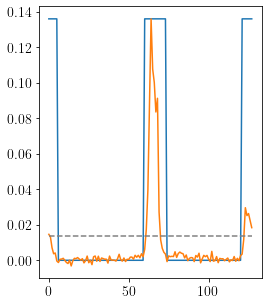

data/J1505-2524_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1505-2524_820MHz_fiore+23.onoff
Width (from .onoff): 7
Duty Cycle (from .onoff): 0.02203
Degr. (from .onoff): 0.97
  SNR (from .onoff): 189.34321



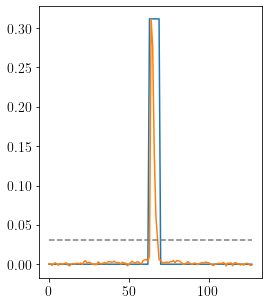

data/J1530-2114_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1530-2114_820MHz_fiore+23.onoff
Width (from .onoff): 8
Duty Cycle (from .onoff): 0.02601
Degr. (from .onoff): 0.74
  SNR (from .onoff): 51.63653



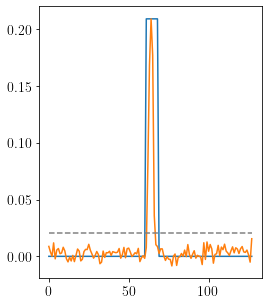

data/J1816+4510_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1816+4510_820MHz_fiore+23.onoff
Width (from .onoff): 29
Duty Cycle (from .onoff): 0.09758
Degr. (from .onoff): 1.0
  SNR (from .onoff): 96.6515



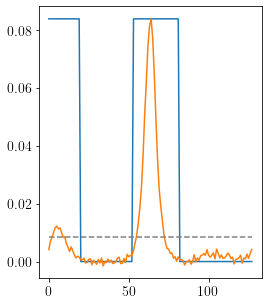

data/J1913+3732_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1913+3732_820MHz_fiore+23.onoff
Width (from .onoff): 7
Duty Cycle (from .onoff): 0.01758
Degr. (from .onoff): 0.11
  SNR (from .onoff): 110.71703



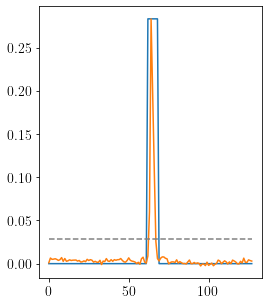

data/J1929+6630_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1929+6630_820MHz_fiore+23.onoff
Width (from .onoff): 6
Duty Cycle (from .onoff): 0.02164
Degr. (from .onoff): 0.81
  SNR (from .onoff): 33.63682



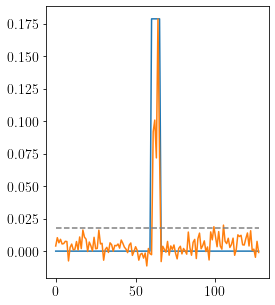

data/J1930+6205_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J1930+6205_820MHz_fiore+23.onoff
Width (from .onoff): 4
Duty Cycle (from .onoff): 0.01589
Degr. (from .onoff): 0.77
  SNR (from .onoff): 35.05942



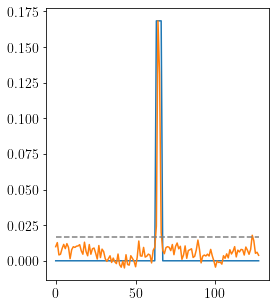

data/J2104+2830_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2104+2830_820MHz_fiore+23.onoff
Width (from .onoff): 5
Duty Cycle (from .onoff): 0.01828
Degr. (from .onoff): 0.75
  SNR (from .onoff): 44.65312



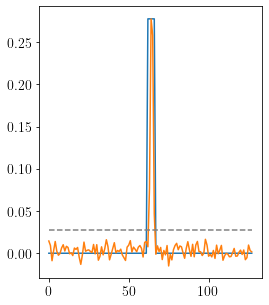

data/J2115+6702_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2115+6702_820MHz_fiore+23.onoff
Width (from .onoff): 11
Duty Cycle (from .onoff): 0.04359
Degr. (from .onoff): 0.93
  SNR (from .onoff): 32.24



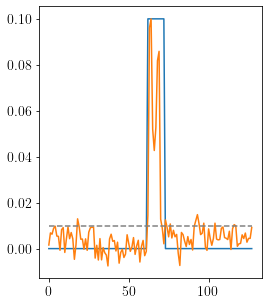

data/J2145+2158_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2145+2158_820MHz_fiore+23.onoff
Width (from .onoff): 7
Duty Cycle (from .onoff): 0.0247
Degr. (from .onoff): 0.95
  SNR (from .onoff): 48.10638



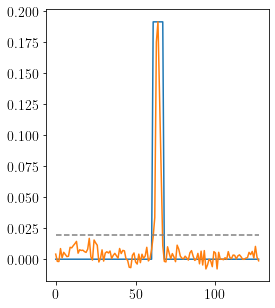

data/J2210+5712_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2210+5712_820MHz_fiore+23.onoff
Width (from .onoff): 6
Duty Cycle (from .onoff): 0.02419
Degr. (from .onoff): 0.82
  SNR (from .onoff): 94.90722



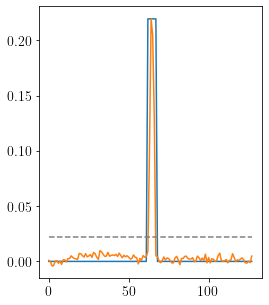

data/J2326+6243_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2326+6243_820MHz_fiore+23.onoff
Width (from .onoff): 12
Duty Cycle (from .onoff): 0.03586
Degr. (from .onoff): 0.97
  SNR (from .onoff): 232.54144



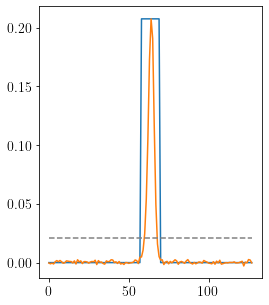

data/J2354-2250_820MHz_fiore+23.onoff
 ON/OFF file exists: data/J2354-2250_820MHz_fiore+23.onoff
Width (from .onoff): 9
Duty Cycle (from .onoff): 0.02629
Degr. (from .onoff): 0.97
  SNR (from .onoff): 56.28127



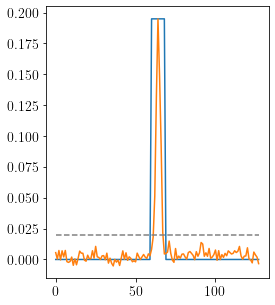

data/J1327+3423_1380MHz_fiore+23.onoff
 ON/OFF file exists: data/J1327+3423_1380MHz_fiore+23.onoff
Width (from .onoff): 31
Duty Cycle (from .onoff): 0.02831
Degr. (from .onoff): 1.0
  SNR (from .onoff): 869.00897



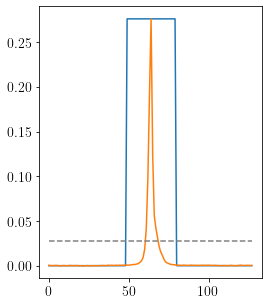

data/J0636+5128_1500MHz_fiore+23.onoff
 ON/OFF file exists: data/J0636+5128_1500MHz_fiore+23.onoff
Width (from .onoff): 16
Duty Cycle (from .onoff): 0.05579
Degr. (from .onoff): 1.0
  SNR (from .onoff): 125.80505



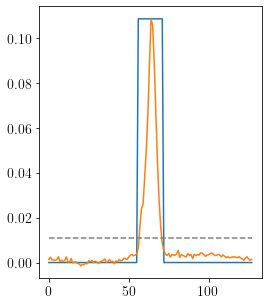

data/J1434+7257_1500MHz_fiore+23.onoff
 ON/OFF file exists: data/J1434+7257_1500MHz_fiore+23.onoff
Width (from .onoff): 1
Duty Cycle (from .onoff): 0.02897
Degr. (from .onoff): 1.0
  SNR (from .onoff): 11.80406



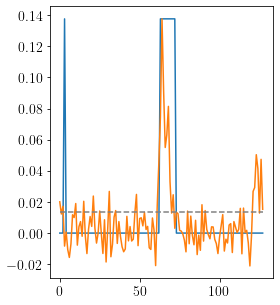

data/J1816+4510_1500MHz_fiore+23.onoff
 ON/OFF file exists: data/J1816+4510_1500MHz_fiore+23.onoff
Width (from .onoff): 17
Duty Cycle (from .onoff): 0.06296
Degr. (from .onoff): 1.0
  SNR (from .onoff): 28.44053



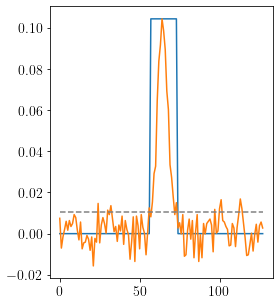

data/J0636+5128_2000MHz_fiore+23.onoff
 ON/OFF file exists: data/J0636+5128_2000MHz_fiore+23.onoff
Width (from .onoff): 18
Duty Cycle (from .onoff): 0.05423
Degr. (from .onoff): 1.0
  SNR (from .onoff): 153.61901



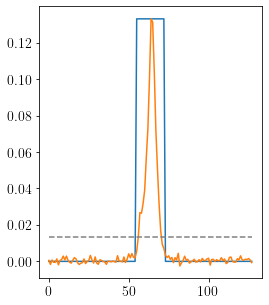

In [119]:
freqs = [57.15,149.0,350.0,430.0,820.0,1380.0,1500.0,2000.0]
for freq in freqs:
    i=0
    try:
        while freq:
            onoff(freq, i, OVERWRITE_ONOFF=False)
            plt.show()
            i+=1
    except IndexError:
        continue

In [4]:
gsm = pygdsm.GlobalSkyModel()

beta = 1.3
Gain_GBT = 2.0   #K/Jy
#SEFD_LWA1 = 10000*u.Jy
#SEFD_LWA1 = 5570*u.Jy
#Ae_LWA1 = 1900*u.m**2
#Trec_LWA1 = 250*u.K
#Gain_LWA1 = (Trec_LWA1/SEFD_LWA1).value
Npol = 2

FluxDict = {}
par_paths = np.sort(glob("data/*fiore+23.par"))
for pp in par_paths:
    with open(pp, 'r') as infile:
        for l in infile.readlines():
            if l.startswith("PSRJ"):
                psr = l.split()[1]
            elif l.startswith("RAJ"):
                ra_str = l.split()[1]
            elif l.startswith("DECJ"):
                dec_str = l.split()[1].strip("+")
            else:
                pass
    onoffs = np.sort(glob(f"data/{psr}*.onoff")) # .onoff files associated with given par
    eqcoord = SkyCoord(ra_str,dec_str,frame=ICRS,unit=(u.hourangle, u.deg))
    gcoord = eqcoord.transform_to(Galactic)
    [Tsky57,Tsky149,Tsky350,Tsky430,Tsky820,Tsky1380,Tsky1500,Tsky2000] = gsm.get_sky_temperature(gcoord, freqs=np.array([57.15,149.0,350.0,430.0,820.0,1380.0,1500.0,2000.0])) # Includes Tcmb

    psrDict = {
        'Flux57':None,
        'errFlux57':None,
        'Flux149':None,
        'errFlux149':None,
        'Flux350':None,
        'errFlux350':None,
        'Flux430':None,
        'errFlux430':None,
        'Flux820':None,
        'errFlux820':None,
        'Flux1380':None,
        'errFlux1380':None,
        'Flux1500':None,
        'errFlux1500':None,
        'Flux2000':None,
        'errFlux2000':None,
        'SI':None,
        'errSI':None,
        'Tobs57':None,
        'Tobs149':None,
        'Tobs327':None,
        'Tobs350':None,
        'Tobs430':None,
        'Tobs820':None,
        'Tobs1380':None,
        'Tobs1500':None,
        'Tobs2000':None,
        'Duty57':None,
        'Duty149':None,
        'Duty327':None,
        'Duty350':None,
        'Duty430':None,
        'Duty820':None,
        'Duty1380':None,
        'Duty1500':None,
        'Duty2000':None}
    
    for oo_file in onoffs:
        
        ooo = OnOff(oo_file)
        
        Gain = Gain_GBT
        bw_err = 10.
        
        use_SEFD=False
        tobs_err=False
        # Get frequency-dependent info
        if "57.15MHz" in oo_file:
            bw = 78.4*0.75 # 25 pct reduction (RFI) note: overlapping bands (true bandwidth ~ 60 MHz)
            bwerr = 78.4*0.1
            #Tsys = Tsky57+250.0 # Uncertainty?
            #Ae_LWA1 = 1900 # m^2 # https://leo.phys.unm.edu/~lwa/obsstatus/obsstatus006.html
            #SEFD = (2.*c.k_B.to(u.J/u.K).value*Tsys/Ae_LWA1)*(10**26) # Jy
            #Gain = Tsys/SEFD
            use_SEFD = True
            SEFD = 5000.*u.Jy
            SEFD_err = 1000.*u.Jy
            flux_key = 'Flux57'
            psrDict['Tobs57'] = ooo.tobs
            psrDict['Duty57'] = ooo.duty
        elif "149MHz" in oo_file:
#             bw = 78.125*0.9 # 10 pct reduction (RFI)
#             bw_err = 78.125*0.1
#             use_SEFD = True
#             SEFD = 3000.*u.Jy
#             SEFD_err = 200.*u.Jy
#             flux_key = 'Flux149'
#             psrDict['Tobs149'] = ooo.tobs
            psrDict['Duty149'] = ooo.duty
        elif "350MHz" in oo_file:
            all_pre_2015 = ["J0415+6111","J0636+5128","J1505-2524","J1530-2114","J1913+3732","J1929+6630","J1930+6205", \
                            "J2104+2830","J2115+6702","J2145+2158","J2210+5712","J2326+6243"]
            all_post_2015 = ["J0141+6303"]
            if psr in all_pre_2015:
                bwdeg = 0.9 # 10 pct reduction (RFI)
                bwerr = 10.0
            elif psr in all_post_2015:
                bwdeg = 0.7 # 30 pct reduction (RFI)
                bwerr = 10.0
            else:
                bwdeg = 0.8 # 20 pct reduction (RFI)
                bwerr = 20.0
            if psr=="J2145+2158" or psr=="J2210+5712":
                tobs_err = 5.0
            bw = 100.0*bwdeg
            Tsys = Tsky350+23.0 # Uncertainty?
            flux_key = 'Flux350'
            psrDict['Tobs350'] = ooo.tobs
            psrDict['Duty350'] = ooo.duty
        elif "430MHz" in oo_file:
            bw = 23.5*0.9 # 10 pct reduction (RFI)
            bwerr = 23.5*0.1
            Tsys = Tsky430+35.0 # Uncertainty?
            Gain = 11 # K/Jy
            flux_key = 'Flux430'
            psrDict['Tobs430'] = ooo.tobs
            psrDict['Duty430'] = ooo.duty
        elif "820MHz" in oo_file:
            bw = 200.*0.9 # 10 pct reduction (RFI)
            bwerr = 20.0
            Tsys = Tsky820+22.0
            flux_key = 'Flux820'
            psrDict['Tobs820'] = ooo.tobs
            psrDict['Duty820'] = ooo.duty
        elif "1380MHz" in oo_file:
            bw = 800*0.75 # 25 pct reduction (RFI and/or smaller bw than file headers suggest)
            bwerr = 80.0
            Tsys = Tsky1380+25.0
            Gain = 10.5 # K/Jy
            flux_key = 'Flux1380'
            psrDict['Tobs1380'] = ooo.tobs
            psrDict['Duty1380'] = ooo.duty
        elif "1500MHz" in oo_file:
            bw = 800*0.9 # 10 pct reduction (RFI)
            bwerr = 80.0
            Tsys = Tsky1500+20.0
            flux_key = 'Flux1500'
            psrDict['Tobs1500'] = ooo.tobs
            psrDict['Duty1500'] = ooo.duty
        elif "2000MHz" in oo_file:
            bw = 800*0.9 # 10 pct reduction (RFI)
            bwerr = 80.0
            Tsys = Tsky2000+18.0
            flux_key = 'Flux2000'
            psrDict['Tobs2000'] = ooo.tobs
            psrDict['Duty2000'] = ooo.duty
        
        if use_SEFD:
            flux = (beta*ooo.snr*SEFD*np.sqrt(ooo.duty/(1-ooo.duty))/(np.sqrt(Npol*(ooo.tobs*u.s)*(bw*u.MHz)))/ooo.deg).to(u.mJy).value
            flux_err = flux*np.sqrt((SEFD_err/SEFD)**2+(bw_err/(2*bw))**2+(((1./128)/(2*ooo.duty))*(1+ooo.duty**(3./2.)/np.sqrt(1-ooo.duty))**-1)**2)
        elif tobs_err:
            flux = (beta*ooo.snr*Tsys*u.K*np.sqrt(ooo.duty/(1-ooo.duty))/((Gain*u.K/u.Jy)*np.sqrt(Npol*(ooo.tobs*u.s)*(bw*u.MHz)))/ooo.deg).to(u.mJy).value
            flux_err = flux*np.sqrt((5.0/Tsys)**2+(bw_err/(2*bw))**2+(tobs_err/(2*tobs))**2+(((1./128)/(2*ooo.duty))*(1+ooo.duty**(3./2.)/np.sqrt(1-ooo.duty))**-1)**2)
        else:
            flux = (beta*ooo.snr*Tsys*u.K*np.sqrt(ooo.duty/(1-ooo.duty))/((Gain*u.K/u.Jy)*np.sqrt(Npol*(ooo.tobs*u.s)*(bw*u.MHz)))/ooo.deg).to(u.mJy).value
            flux_err = flux*np.sqrt((5.0/Tsys)**2+(bw_err/(2*bw))**2+(((1./128)/(2*ooo.duty))*(1+ooo.duty**(3./2.)/np.sqrt(1-ooo.duty))**-1)**2)
        
        # Main contributors to uncertainty = Tsys (5 K), degradation (factor due to offset, 5-30%), bw (10 MHz? more for 350)
        #deg_err = min((1.0-ooo.deg)/2.0,0.05)
#         if flux_key=='Flux57': 
#             gain_err = Gain*np.sqrt((5.0/250.0)**2+0.5**2) # assume 50% error in SEFD
#             flux_err = flux*np.sqrt((deg_err/ooo.deg)**2+(gain_err/Gain)**2+(5.0/Tsys)**2+(10.0/(2*bw))**2+(((1./128)/(2*ooo.duty))*(1+ooo.duty**(3./2.)/np.sqrt(1-ooo.duty))**-1)**2)
#         else:
        #flux_err = flux*np.sqrt((deg_err/ooo.deg)**2+(5.0/Tsys)**2+(bw_err/(2*bw))**2+(((1./128)/(2*ooo.duty))*(1+ooo.duty**(3./2.)/np.sqrt(1-ooo.duty))**-1)**2)
        psrDict[flux_key] = flux
        psrDict[f"err{flux_key}"] = flux_err
        
        #print(f"{oo_file}: {flux:.3f}+/-{flux_err:.3f} mJy")
        #print(flux_key)
#     if psr=="J0957-0619":
#         peak_flux = 160.
#         peak_flux_err = 0.5*peak_flux
#         flux = peak_flux*ooo.duty
#         flux_err = flux*np.sqrt((peak_flux_err/peak_flux)**2+1.)
#         psrDict['Flux350'] = flux
#         psrDict['errFlux350'] = flux_err
#         psrDict['Tobs350'] = 0.
#         psrDict['Duty350'] = 0.1
#         psrDict['Flux820'] *= 2

    if psr=="J1816+4510": # place S-band limit assuming nondetection
        tobs = 614.970+141.179+242.021
        bw = 800.0
        Tsys = Tsky2000+18.0
        duty = 0.06
        deg = 1.0
        flux_limit = (beta*6.0*Tsys*u.K*np.sqrt(duty/(1-duty))/((Gain*u.K/u.Jy)*np.sqrt(Npol*(tobs*u.s)*(bw*u.MHz)))/deg).to(u.mJy).value
        print(f"S-band flux limit: {flux_limit:.2f} mJy")
    
    # Calculate spectral indices (and error!)
    all_fluxes  = [psrDict['Flux57'],psrDict['Flux149'],psrDict['Flux350'],psrDict['Flux430'],psrDict['Flux820'],psrDict['Flux1380'],psrDict['Flux1500'],psrDict['Flux2000']]  
    flux_exists = [S is not None for S in all_fluxes]
    fluxes      = np.array(all_fluxes)[flux_exists]
    freqs       = np.array([57.15, 149.0, 350.0, 430.0, 820.0, 1380.0, 1500.0, 2000.0])[flux_exists]
    flux_errs   = np.array([psrDict['errFlux57'],psrDict['errFlux149'],psrDict['errFlux350'],psrDict['errFlux430'],psrDict['errFlux820'],psrDict['errFlux1380'],psrDict['errFlux1500'],psrDict['errFlux2000']])[flux_exists]
    if len(fluxes) == 2:
        si = get_si(freqs[0], fluxes[0], freqs[1], fluxes[1])
        psrDict['SI'] = si
        a = np.abs(1.0/(np.log(freqs[1]/freqs[0])))
        coeff = np.exp(0.5*(np.log(fluxes[0]*fluxes[1])-np.log(fluxes[1]/fluxes[0])*np.log(freqs[0]*freqs[1])/np.log(freqs[1]/freqs[0])))
        psrDict['coeff'] = coeff
        si_err = a*np.sqrt((flux_errs[0]/fluxes[0])**2+(flux_errs[1]/fluxes[1])**2)
        psrDict['errSI'] = si_err
        print(f"Spectral index for {psr}: {si:.2f} +/- {si_err:.2f}")
    elif len(fluxes) > 2:
        si, si_err, coeff = get_si_multi(freqs, fluxes, list(flux_errs))
        psrDict['SI'] = si
        psrDict['errSI'] = si_err
        psrDict['coeff'] = coeff
        print(f"Spectral index for {psr}: {si:.2f} +/- {si_err:.2f} (least-squares fit)")
    else:
        print(f"{psr} does not have enough info to calculate spectral index.")
        
    if si_err > np.abs(si):
        print(f"Spectral index is not well constrained for {psr}.")
        
    FluxDict[psr] = psrDict

Spectral index for J0032+6946: -0.26 +/- 0.31
Spectral index is not well constrained for J0032+6946.
Spectral index for J0141+6303: -1.22 +/- 0.27
Spectral index for J0214+5222: -0.72 +/- 0.25
Spectral index for J0415+6111: -1.95 +/- 0.26
Spectral index for J0636+5128: -1.25 +/- 0.33 (least-squares fit)
J0957-0619 does not have enough info to calculate spectral index.
Spectral index for J1239+3239: -0.20 +/- 0.26
Spectral index is not well constrained for J1239+3239.
Spectral index for J1327+3423: -1.85 +/- 0.15 (least-squares fit)
Spectral index for J1434+7257: -1.39 +/- 0.06 (least-squares fit)
Spectral index for J1505-2524: -1.40 +/- 0.39
Spectral index for J1530-2114: -1.38 +/- 0.34
S-band flux limit: 0.02 mJy
Spectral index for J1816+4510: -2.91 +/- 0.39 (least-squares fit)
Spectral index for J1913+3732: -0.74 +/- 0.42
Spectral index for J1929+6630: -1.97 +/- 0.35
Spectral index for J1930+6205: -1.98 +/- 0.45
Spectral index for J2104+2830: -1.88 +/- 0.41
Spectral index for J2115+6

In [ ]:
# import table_utils as tu

# # WRITE TABLE LINES

# psrs_more_freq = ["J0636+5128", "J1434+7257", "J1816+4510"]

# for psr in FluxDict.keys():
#     pD = FluxDict[psr]
#     if psr in psrs_more_freq or psr=="J1327+3423":
#         continue
#     if pD['Flux350']:
#         S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
#         tobs350str = f"{int(pD['Tobs350'])}"
#         duty350str = f"{pD['Duty350']:.2f}"
#     else:
#         S350_tex = "--"
#         tobs350str = "--"
#         duty350str = "--"
#     if pD['Flux820']:
#         S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
#         tobs820str = f"{int(pD['Tobs820'])}"
#         duty820str = f"{pD['Duty820']:.2f}"
#     if pD['SI'] is not None:
#         SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
#     else:
#         SI_tex = "--"

#     tex_line = f"{psr} & {tobs350str} & {duty350str} & {S350_tex} & & " + \
#                f"{tobs820str} & {duty820str} & {S820_tex} & {SI_tex} \\\\"
#     print(tex_line.replace("-","$-$").replace("$-$$-$","--"))
    
# for psr in psrs_more_freq:
#     pD = FluxDict[psr]
#     if pD['Flux350']:
#         S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
#         tobs350str = f"{int(pD['Tobs350'])}"
#         duty350str = f"{pD['Duty350']:.2f}"
#     else:
#         S350_tex = "--"
#         tobs350str = "--"
#         duty350str = "--"
#     if pD['Flux820']:
#         S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
#         tobs820str = f"{int(pD['Tobs820'])}"
#         duty820str = f"{pD['Duty820']:.2f}"
#     if pD['Flux1500']:
#         S1500_tex = tu.ufve(pD['Flux1500'],pD['errFlux1500'],digits=tu.digits_for_unc(pD['errFlux1500']))
#         tobs1500str = f"{int(pD['Tobs1500'])}"
#         duty1500str = f"{pD['Duty1500']:.2f}"
#     else:
#         S1500_tex = "--"
#         tobs1500str = "--"
#         duty1500str = "--"
#     if pD['Flux2000']:
#         S2000_tex = tu.ufve(pD['Flux2000'],pD['errFlux2000'],digits=tu.digits_for_unc(pD['errFlux2000']))
#         tobs2000str = f"{int(pD['Tobs2000'])}"
#         duty2000str = f"{pD['Duty2000']:.2f}"
#     else:
#         S2000_tex = "--"
#         tobs2000str = "--"
#         duty2000str = "--"
#     if pD['SI'] is not None:
#         SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
#     else:
#         SI_tex = "--"

#     tex_line = f"{psr} & {tobs350str} & {duty350str} & {S350_tex} & & " + \
#                f"{tobs820str} & {duty820str} & {S820_tex} & & " + \
#                f"{tobs1500str} & {duty1500str} & {S1500_tex} & & " + \
#                f"{tobs2000str} & {duty2000str} & {S2000_tex} & {SI_tex} \\\\"
#     print(tex_line.replace("-","$-$").replace("$-$$-$","--"))
    
# psr = "J1327+3423"
# pD = FluxDict[psr]
# S57_tex = tu.ufve(pD['Flux57'],pD['errFlux57'],digits=tu.digits_for_unc(pD['errFlux57']))
# tobs57str = f"{int(pD['Tobs57'])}"
# duty57str = f"{pD['Duty57']:.2f}"

# S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
# tobs350str = f"{int(pD['Tobs350'])}"
# duty350str = f"{pD['Duty350']:.2f}"

# S430_tex = tu.ufve(pD['Flux430'],pD['errFlux430'],digits=tu.digits_for_unc(pD['errFlux430']))
# tobs430str = f"{int(pD['Tobs430'])}"
# duty430str = f"{pD['Duty430']:.2f}"

# S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
# tobs820str = f"{int(pD['Tobs820'])}"
# duty820str = f"{pD['Duty820']:.2f}"

# S1380_tex = tu.ufve(pD['Flux1380'],pD['errFlux1380'],digits=tu.digits_for_unc(pD['errFlux1380']))
# tobs1380str = f"{int(pD['Tobs1380'])}"
# duty1380str = f"{pD['Duty1380']:.2f}"

# SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))

# tex_line = f"{psr} & {tobs57str} & {duty57str} & {S57_tex} & & " + \
#            f"{tobs350str} & {duty350str} & {S350_tex} & & " + \
#            f"{tobs430str} & {duty430str} & {S430_tex} & & " + \
#            f"{tobs820str} & {duty820str} & {S820_tex} & & " + \
#            f"{tobs1380str} & {duty1380str} & {S1380_tex} & {SI_tex} \\\\"
# print(tex_line.replace("-","$-$").replace("$-$$-$","--"))

This is just the same as the previous cell, but for putting everything in one big table, omitting duty cycles:

In [6]:
import table_utils as tu

# WRITE TABLE LINES

for psr in FluxDict.keys():
    pD = FluxDict[psr]
    if pD['Flux57']:
        Slow_tex = tu.ufve(pD['Flux57'],pD['errFlux57'],digits=tu.digits_for_unc(pD['errFlux57']))
        tobslowstr = f"{int(pD['Tobs57'])}"
    elif pD['Flux149']:
        Slow_tex = tu.ufve(pD['Flux149'],pD['errFlux149'],digits=tu.digits_for_unc(pD['errFlux149']))
        tobslowstr = f"{int(pD['Tobs149'])}"
    else:
        Slow_tex = "\ldots"
        tobslowstr = "\ldots\phn\phd"
    if pD['Flux350']:
        S350_tex = tu.ufve(pD['Flux350'],pD['errFlux350'],digits=tu.digits_for_unc(pD['errFlux350']))
        if len(S350_tex)==7:
            S350_tex = f"{S350_tex}\phn"
        elif len(S350_tex)==6:
            S350_tex = f"{S350_tex}\dphn"
        tobs350str = f"{int(pD['Tobs350'])}"
    else:
        S350_tex = "\ldots"
        tobs350str = "\ldots\phd"
    if pD['Flux430']:
        S430_tex = tu.ufve(pD['Flux430'],pD['errFlux430'],digits=tu.digits_for_unc(pD['errFlux430']))
        tobs430str = f"{int(pD['Tobs430'])}"
    else:
        S430_tex = "\ldots"
        tobs430str = "\ldots\phn"
    if pD['Flux820']:
        S820_tex = tu.ufve(pD['Flux820'],pD['errFlux820'],digits=tu.digits_for_unc(pD['errFlux820']))
        if len(S820_tex)==8:
            S820_tex = f"{S820_tex}\phn"
        elif len(S820_tex)==7:
            S820_tex = f"{S820_tex}\dphn"
        elif len(S820_tex)==6:
            S820_tex = f"{S820_tex}\\tphn"
        tobs820str = f"{int(pD['Tobs820'])}"
    if pD['Flux1500']:
        SLband_tex = tu.ufve(pD['Flux1500'],pD['errFlux1500'],digits=tu.digits_for_unc(pD['errFlux1500']))
        tobsLbandstr = f"{int(pD['Tobs1500'])}"
    elif pD['Flux1380']:
        SLband_tex = "\\textit{"+tu.ufve(pD['Flux1380'],pD['errFlux1380'],digits=tu.digits_for_unc(pD['errFlux1380']))+"}"
        tobsLbandstr = "\\textit{"+f"{int(pD['Tobs1380'])}"+"}"
    else:
        SLband_tex = "\ldots"
        tobsLbandstr = "\ldots"
    if pD['Flux2000']:
        S2000_tex = tu.ufve(pD['Flux2000'],pD['errFlux2000'],digits=tu.digits_for_unc(pD['errFlux2000']))
        tobs2000str = f"{int(pD['Tobs2000'])}"
    else:
        S2000_tex = "\ldots"
        tobs2000str = "\ldots\phd"
    if pD['SI'] is not None:
        #SI_tex = "\\phm{$<$}"+tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
        if psr=="J1327+3423":
            SI_tex = tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))
        else:
            SI_tex = f"{tu.ufve(pD['SI'],pD['errSI'],digits=tu.digits_for_unc(pD['errSI']))}\dphn"
        if pD['SI']>0.0:
            SI_tex = f"\phnm{SI_tex}"
    else:
        SI_tex = "\ldots"

    tex_line = f"{psr} & {tobslowstr} & {Slow_tex} & " + \
               f"{tobs350str} & {S350_tex} & " + \
               f"{tobs430str} & {S430_tex} & " + \
               f"{tobs820str} & {S820_tex} & " + \
               f"{tobsLbandstr} & {SLband_tex} & " + \
               f"{tobs2000str} & {S2000_tex} & {SI_tex} \\\\"
    print(tex_line.replace("-","$-$").replace(" \\times ","$\\times$").replace("^","$^"))

J0032+6946 & \ldots\phn\phd & \ldots & 3925 & 0.34(4)\phn & \ldots\phn & \ldots & 3856 & 0.27(6)\dphn & \ldots & \ldots & \ldots\phd & \ldots & $-$0.3(3)\dphn \\
J0141+6303 & \ldots\phn\phd & \ldots & 7240 & 0.62(7)\phn & \ldots\phn & \ldots & 10089 & 0.22(4)\dphn & \ldots & \ldots & \ldots\phd & \ldots & $-$1.2(3)\dphn \\
J0214+5222 & \ldots\phn\phd & \ldots & 4890 & 0.68(8)\phn & \ldots\phn & \ldots & 14395 & 0.37(6)\dphn & \ldots & \ldots & \ldots\phd & \ldots & $-$0.7(2)\dphn \\
J0415+6111 & \ldots\phn\phd & \ldots & 111 & 1.19(14) & \ldots\phn & \ldots & 5428 & 0.23(4)\dphn & \ldots & \ldots & \ldots\phd & \ldots & $-$1.9(3)\dphn \\
J0636+5128 & \ldots\phn\phd & \ldots & 7433 & 1.21(15) & \ldots\phn & \ldots & 28626 & 1.2(2)\tphn & 5934 & 0.16(4) & 5401 & 0.18(4) & $-$1.2(3)\dphn \\
J0957$-$0619 & \ldots\phn\phd & \ldots & \ldots\phd & \ldots & \ldots\phn & \ldots & 7820 & 0.08(2)\dphn & \ldots & \ldots & \ldots\phd & \ldots & \ldots \\
J1239+3239 & \ldots\phn\phd & \ldots & 11953

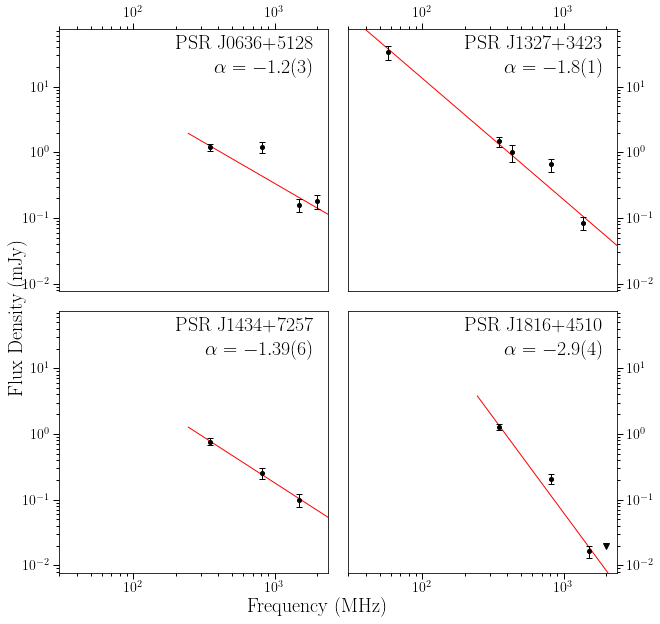

In [10]:
import matplotlib as mpl
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
fig_width = 4.0
fig_height = 5.0  #fig_width*0.6
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
          'font.size'      : 30*fig_width/8.5,
          'axes.labelsize' : 30*fig_width/8.5,
          'xtick.labelsize': 30*fig_width/8.5,
          'ytick.labelsize': 30*fig_width/8.5,
          'text.usetex'    : True,
          'figure.figsize' : fig_size,
          'axes.unicode_minus': True}
mpl.rcParams.update(params)
fig = plt.figure(figsize=(10, 10))
#fig.tight_layout()
plt.subplots_adjust(hspace=0.075)
plt.subplots_adjust(wspace=0.075)
n=0
for psr in FluxDict.keys():
    pD = FluxDict[psr]
    freqs     = []
    fluxes    = []
    flux_errs = []
    if pD['Flux57']:
        freqs.append(57.15)
        fluxes.append(pD['Flux57'])
        flux_errs.append(pD['errFlux57'])
    if pD['Flux149']:
        freqs.append(149.0)
        fluxes.append(pD['Flux149'])
        flux_errs.append(pD['errFlux149'])
    if pD['Flux350']:
        freqs.append(350.0)
        fluxes.append(pD['Flux350'])
        flux_errs.append(pD['errFlux350'])
    if pD['Flux430']:
        freqs.append(430.0)
        fluxes.append(pD['Flux430'])
        flux_errs.append(pD['errFlux430'])
    if pD['Flux820']:
        freqs.append(820.0)
        fluxes.append(pD['Flux820'])
        flux_errs.append(pD['errFlux820'])
    if pD['Flux1380']:
        freqs.append(1380.0)
        fluxes.append(pD['Flux1380'])
        flux_errs.append(pD['errFlux1380'])
    if pD['Flux1500']:
        freqs.append(1500.0)
        fluxes.append(pD['Flux1500'])
        flux_errs.append(pD['errFlux1500'])
    if pD['Flux2000']:
        freqs.append(2000.0)
        fluxes.append(pD['Flux2000'])
        flux_errs.append(pD['errFlux2000'])
    if len(fluxes) > 2:
        n+=1
        SI     = pD['SI']
        SI_err = pD['errSI']
        SI_tex = tu.ufve(SI,SI_err)
        coeff  = pD['coeff']
        freq_i = min(freqs)*0.7
        #freq_f = max(freqs)+300.0
        freq_f = 2400.0
        #n = (freq_f-freq_i)/0.1
        fs = np.arange(freq_i,freq_f,0.1)
        power_law = powerlaw(fs,coeff,SI)
#         ax = plt.subplot(2,3,n)
        ax = plt.subplot(2,2,n)
        ax.plot(fs,power_law,c='r',linestyle='-',linewidth=1)
        ax.errorbar(freqs,fluxes,yerr=flux_errs,fmt='o',ms=4,capsize=3,elinewidth=1,c='black')
        if psr=="J1816+4510":
            ax.plot(2000.0,0.02,c='black',marker='v')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.text(0.95,0.94,f"PSR {psr}",color='black',rotation=0,size=20,va='center',ha='right',transform=ax.transAxes)
        #ax.text(0.95,0.85,f"$\\alpha = {SI_tex.split('(')[0]}\\pm0.{SI_tex.strip(')').split('(')[1]}$",color='black',rotation=0,size=20,va='center',ha='right',transform=ax.transAxes)
        ax.text(0.95,0.85,f"$\\alpha = {SI_tex}$",color='black',rotation=0,size=20,va='center',ha='right',transform=ax.transAxes)
        ax.xaxis.set_minor_formatter(plt.NullFormatter())
#         ax.set_xticks([100.,300.,1000.,2000.])
#         ax.set_xticklabels(["100","300","1000","2000"],fontsize=14)
#         ax.set_yticks([0.1,1.,10.,100.,1000.])
#         ax.set_yticklabels(["0.1","1","10","100","1000"],fontsize=14)
#         ax.set_xlim([freq_i,freq_f])
#         ax.set_ylim([0.65*min(fluxes),1.45*(max(fluxes)+max(flux_errs))])
        ax.set_xlim(30.,2400.)
        ax.set_ylim(0.0077,75.)
        ax.tick_params(length=6,width=1,which='major')
        ax.tick_params(length=3,width=1,which='minor')
        if n==1:
            ax.xaxis.tick_top()
            ax.text(-0.12,-0.1,"Flux Density (mJy)",color='black',rotation=90,size=20,va='center',ha='right',transform=ax.transAxes)
        elif n==2:
            ax.xaxis.tick_top()
            ax.yaxis.tick_right()
            #ax.text(0.15,1.15,"Frequency (MHz)",color='black',rotation=0,size=16,va='center',ha='right',transform=ax.transAxes)
            #ax.text(1.15,-0.1,"Flux Density (mJy)",color='black',rotation=90,size=16,va='center',ha='right',transform=ax.transAxes)
        elif n==4:
            ax.yaxis.tick_right()
            ax.text(0.15,-0.13,"Frequency (MHz)",color='black',rotation=0,size=20,va='center',ha='right',transform=ax.transAxes)
plt.savefig("spectra.pdf",format='pdf',bbox_inches='tight',pad_inches=0.25)
plt.show()

In [156]:
for psr in FluxDict.keys():
    par_path = f"data/{psr}_fiore+23.par"
    with open(par_path, 'r') as infile:
        for l in infile.readlines():
            if l.startswith("F0"):
                f0 = float(l.split()[1])
                period = 1000./f0 # milliseconds
    pD = FluxDict[psr]
    if pD['Duty57']:
        duty57str = f"{pD['Duty57']:.2f}"
        weq57 = pD['Duty57']*period
        if weq57 >= 10.0:
            weq57str = f"{weq57:.0f}\phn\phd"
        else:
            weq57str = f"{weq57:.1f}"
    else:
        duty57str = "\ldots"
        weq57str = "\ldots"
    if pD['Duty149']:
        duty149str = f"{pD['Duty149']:.2f}"
        weq149 = pD['Duty149']*period
        if weq149 >= 10.0:
            weq149str = f"{weq149:.0f}\phn\phd"
        else:
            weq149str = f"{weq149:.1f}"
    else:
        duty149str = "\ldots"
        weq149str = "\ldots"
    if pD['Duty350']:
        duty350str = f"{pD['Duty350']:.2f}"
        weq350 = pD['Duty350']*period
        if weq350 >= 10.0:
            weq350str = f"{weq350:.0f}\phn\phd"
        else:
            weq350str = f"{weq350:.1f}"
    else:
        duty350str = "\ldots"
        weq350str = "\ldots"
    if pD['Duty430']:
        duty430str = f"{pD['Duty430']:.2f}"
        weq430 = pD['Duty430']*period
        if weq430 >= 10.0:
            weq430str = f"{weq430:.0f}\phn\phd"
        else:
            weq430str = f"{weq430:.1f}"
    else:
        duty430str = "\ldots"
        weq430str = "\ldots"
    if pD['Duty820']:
        duty820str = f"{pD['Duty820']:.2f}"
        weq820 = pD['Duty820']*period
        if weq820 >= 10.0:
            weq820str = f"{weq820:.0f}\phn\phd"
        else:
            weq820str = f"{weq820:.1f}"
    else:
        duty820str = "\ldots"
        weq820str = "\ldots"
    if pD['Duty1500']:
        duty1500str = f"{pD['Duty1500']:.2f}"
        weq1500 = pD['Duty1500']*period
        if weq1500 >= 10.0:
            weq1500str = f"{weq1500:.0f}\phn\phd"
        else:
            weq1500str = f"{weq1500:.1f}"
    elif pD['Duty1380']:
        duty1500str = f"{pD['Duty1380']:.2f}"
        weq1500 = pD['Duty1380']*period
        if weq1500 >= 10.0:
            weq1500str = f"{weq1500:.0f}\phn\phd"
        else:
            weq1500str = f"{weq1500:.1f}"
    else:
        duty1500str = "\ldots"
        weq1500str = "\ldots"
    if pD['Duty2000']:
        duty2000str = f"{pD['Duty2000']:.2f}"
        weq2000 = pD['Duty2000']*period
        if weq2000 >= 10.0:
            weq2000str = f"{weq2000:.0f}\phn\phd"
        else:
            weq2000str = f"{weq2000:.1f}"
    else:
        duty2000str = "\ldots"
        weq2000str = "\ldots"

    tex_line = f"{psr} & {duty57str} & {weq57str} & {duty149str} & {weq149str} & {duty350str} & {weq350str} & {duty430str} & {weq430str} \
    & {duty820str} & {weq820str} & {duty1500str} & {weq1500str} & {duty2000str} & {weq2000str} \\\\"
    print(tex_line.replace("-","$-$").replace("$-$$-$","--"))

J0032+6946 & \ldots & \ldots & \ldots & \ldots & 0.04 & 1.4 & \ldots & \ldots     & 0.02 & 0.9 & \ldots & \ldots & \ldots & \ldots \\
J0141+6303 & \ldots & \ldots & \ldots & \ldots & 0.05 & 2.4 & \ldots & \ldots     & 0.03 & 1.3 & \ldots & \ldots & \ldots & \ldots \\
J0214+5222 & \ldots & \ldots & 0.06 & 1.4 & 0.05 & 1.1 & \ldots & \ldots     & 0.21 & 5.2 & \ldots & \ldots & \ldots & \ldots \\
J0415+6111 & \ldots & \ldots & \ldots & \ldots & 0.04 & 19\phn\phd & \ldots & \ldots     & 0.04 & 19\phn\phd & \ldots & \ldots & \ldots & \ldots \\
J0636+5128 & \ldots & \ldots & \ldots & \ldots & 0.05 & 0.1 & \ldots & \ldots     & 0.05 & 0.1 & 0.06 & 0.2 & 0.05 & 0.2 \\
J0957$-$0619 & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots     & 0.02 & 34\phn\phd & \ldots & \ldots & \ldots & \ldots \\
J1239+3239 & \ldots & \ldots & \ldots & \ldots & 0.24 & 1.2 & \ldots & \ldots     & 0.34 & 1.6 & \ldots & \ldots & \ldots & \ldots \\
J1327+3423 & 0.03 & 1.4 & \ldots & \ldots & 0.03 

In [157]:
# WRITE FILE WITH FLUX INFO FOR PLOTTING PROFILES

with open('data/flux.info','w') as f:
    f.write("# name s57 s149 s350 s430 s820 s1380 s1500 s2000 \n")
    for psr in FluxDict.keys():
        pD = FluxDict[psr]
        if pD['Flux57']:
            s57 = f"{pD['Flux57']:.2f}"
        else:
            s57 = "--"
        if pD['Flux149']:
            s149 = f"{pD['Flux149']:.2f}"
        else:
            s149 = "--"
        if pD['Flux350']:
            s350 = f"{pD['Flux350']:.2f}"
        else:
            s350 = "--"
        if pD['Flux430']:
            s430 = f"{pD['Flux430']:.2f}"
        else:
            s430 = "--"
        if pD['Flux820']:
            s820 = f"{pD['Flux820']:.2f}"
        else:
            s820 = "--"
        if pD['Flux1380']:
            s1380 = f"{pD['Flux1380']:.2f}"
        else:
            s1380 = "--"
        if pD['Flux1500']:
            s1500 = f"{pD['Flux1500']:.2f}"
        else:
            s1500 = "--"
        if pD['Flux2000']:
            s2000 = f"{pD['Flux2000']:.2f}"
        else:
            s2000 = "--"
        info_line = f"{psr} {s57} {s149} {s350} {s430} {s820} {s1380} {s1500} {s2000} \n"
        f.write(info_line)

In [ ]:
`